# DPO vs RLHF

**A comprehensive comparison**

## Training Pipeline Comparison

### RLHF Pipeline
```
1. Supervised Fine-Tuning (SFT)
2. Train Reward Model on preferences
3. PPO with reward model feedback
```

### DPO Pipeline
```
1. Supervised Fine-Tuning (SFT)
2. DPO on preference pairs
```

DPO eliminates the entire reward model stage!

## Memory Requirements

| Method | Models in Memory | Memory Factor |
|--------|-----------------|---------------|
| **RLHF** | Policy, Value, Reward, Reference | ~4x |
| **DPO** | Policy, Reference | ~2x |

DPO uses **half the memory** of RLHF!

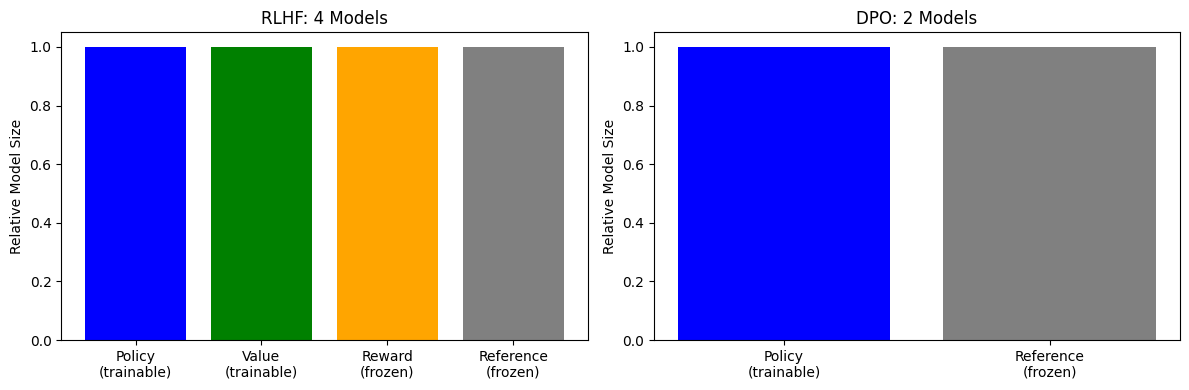

In [1]:
# Memory comparison visualization
import matplotlib.pyplot as plt
import numpy as np

methods = ['RLHF', 'DPO']
models = {
    'RLHF': ['Policy', 'Value', 'Reward', 'Reference'],
    'DPO': ['Policy', 'Reference']
}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RLHF
axes[0].bar(range(4), [1, 1, 1, 1], color=['blue', 'green', 'orange', 'gray'])
axes[0].set_xticks(range(4))
axes[0].set_xticklabels(['Policy\n(trainable)', 'Value\n(trainable)', 'Reward\n(frozen)', 'Reference\n(frozen)'])
axes[0].set_ylabel('Relative Model Size')
axes[0].set_title('RLHF: 4 Models')

# DPO
axes[1].bar(range(2), [1, 1], color=['blue', 'gray'])
axes[1].set_xticks(range(2))
axes[1].set_xticklabels(['Policy\n(trainable)', 'Reference\n(frozen)'])
axes[1].set_ylabel('Relative Model Size')
axes[1].set_title('DPO: 2 Models')

plt.tight_layout()
plt.show()

## Stability Comparison

| Issue | RLHF | DPO |
|-------|------|-----|
| **Reward hacking** | Common | Rare |
| **Mode collapse** | Possible | Rare |
| **Training instability** | Common | Rare |
| **Hyperparameter sensitivity** | High | Low |

DPO is significantly more stable because it's just supervised learning!

## Sample Efficiency

| Aspect | RLHF | DPO |
|--------|------|-----|
| **Data used** | Prompts only (generates responses) | Full preference pairs |
| **Requires** | Many prompts for rollouts | Preference pairs |
| **Data efficiency** | Lower | Higher |

## Flexibility

| Aspect | RLHF | DPO |
|--------|------|-----|
| **Reward iteration** | Easy (just retrain RM) | Hard (retrain everything) |
| **Multi-objective** | Easy (multiple RMs) | Complex |
| **Online learning** | Natural (generate + score) | Difficult |

In [2]:
# Summary comparison table
comparison = {
    'Criterion': ['Simplicity', 'Memory', 'Stability', 'Sample Efficiency', 'Flexibility', 'Training Time'],
    'RLHF': ['Low', '4x', 'Moderate', 'Lower', 'High', 'Longer'],
    'DPO': ['High', '2x', 'High', 'Higher', 'Moderate', 'Shorter'],
    'Winner': ['DPO', 'DPO', 'DPO', 'DPO', 'RLHF', 'DPO']
}

print("Summary Comparison:")
print("="*60)
print(f"{'Criterion':<20} {'RLHF':<12} {'DPO':<12} {'Winner':<12}")
print("-"*60)
for i in range(len(comparison['Criterion'])):
    print(f"{comparison['Criterion'][i]:<20} {comparison['RLHF'][i]:<12} {comparison['DPO'][i]:<12} {comparison['Winner'][i]:<12}")

Summary Comparison:
Criterion            RLHF         DPO          Winner      
------------------------------------------------------------
Simplicity           Low          High         DPO         
Memory               4x           2x           DPO         
Stability            Moderate     High         DPO         
Sample Efficiency    Lower        Higher       DPO         
Flexibility          High         Moderate     RLHF        
Training Time        Longer       Shorter      DPO         


## When to Choose Each

### Choose DPO if:
- You're new to preference learning
- Memory is limited
- You want stable, predictable training
- You have good quality preference data

### Choose RLHF if:
- You need to iterate on the reward function
- You have many prompts but limited preferences
- You need maximum control over alignment
- You're scaling to very large models

## Next Steps

Let's dive deeper into the DPO loss function and understand the mathematics.